In [2]:
# =========================================================
# 0) IMPORTS / SETUP
# =========================================================
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers, ops


# =========================================================
# 1) DATA LOADING
# =========================================================
data_dir = Path("../data/all_captcha_png_shuffled/")
all_images = sorted(list(data_dir.glob("*.png")))
all_labels = [img.stem.lower() for img in all_images]

print("Total images:", len(all_images))

np.random.seed(42)
N_SAMPLES = 10_000
idx = np.random.choice(len(all_images), min(N_SAMPLES, len(all_images)), replace=False)

images = np.array([str(all_images[i]) for i in idx])
labels = np.array([all_labels[i] for i in idx])

perm = np.random.permutation(len(images))
images, labels = images[perm], labels[perm]

split = int(0.8 * len(images))
x_train, x_val = images[:split], images[split:]
y_train, y_val = labels[:split], labels[split:]


# =========================================================
# 2) VOCAB (CTC SAFE)
# =========================================================
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
num_chars = len(characters)          # 36
num_classes = num_chars + 1          # + blank

char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0,   # indices 0..35
)

num_to_char = tf.constant(characters)

img_width = 200
img_height = 50
batch_size = 16


# =========================================================
# 3) DATASET
# =========================================================
def encode_sample(img_path, label_str):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, [1, 0, 2])  # (W, H, 1)

    label = char_to_num(tf.strings.unicode_split(label_str, "UTF-8"))
    label = tf.cast(label, tf.int32)

    return {"image": img, "label": label}

def make_dataset(x, y):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(
        batch_size,
        padded_shapes={"image": [img_width, img_height, 1], "label": [None]},
        padding_values={
            "image": tf.constant(0.0, tf.float32),
            "label": tf.constant(-1, tf.int32),  # padding labels
        },
    )
    return ds.prefetch(tf.data.AUTOTUNE)

train_dataset = make_dataset(x_train, y_train)
val_dataset = make_dataset(x_val, y_val)


# =========================================================
# 4) CTC UTILS
# =========================================================
def dense_to_sparse(labels, label_len):
    mask = tf.sequence_mask(label_len, maxlen=tf.shape(labels)[1])
    mask = tf.logical_and(mask, labels >= 0)
    mask = tf.logical_and(mask, labels < num_chars)

    idx = tf.where(mask)
    vals = tf.gather_nd(labels, idx)

    return tf.SparseTensor(
        indices=tf.cast(idx, tf.int64),
        values=tf.cast(vals, tf.int32),
        dense_shape=tf.cast(tf.shape(labels), tf.int64),
    )

def ctc_loss(y_true, y_pred, input_len, label_len):
    sparse = dense_to_sparse(y_true, label_len)
    y_pred = tf.math.log(tf.transpose(y_pred, [1, 0, 2]) + keras.backend.epsilon())
    loss = tf.nn.ctc_loss(
        labels=sparse,
        logits=y_pred,
        label_length=label_len,
        logit_length=input_len,
        blank_index=num_chars,
    )
    return tf.expand_dims(loss, axis=1)

class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch = tf.shape(y_true)[0]
        input_len = tf.fill([batch], tf.shape(y_pred)[1])
        label_len = tf.reduce_sum(tf.cast(y_true >= 0, tf.int32), axis=1)

        loss = ctc_loss(y_true, y_pred, input_len, label_len)
        self.add_loss(tf.reduce_mean(loss))
        return y_pred


# =========================================================
# 5) MODEL
# =========================================================
def build_model():
    img_in = layers.Input(shape=(img_width, img_height, 1), name="image")
    lbl_in = layers.Input(shape=(None,), dtype="int32", name="label")

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(img_in)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 1))(x)

    x = layers.Reshape((img_width // 4, (img_height // 2) * 128))(x)
    x = layers.Dense(128, activation="relu")(x)

    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    y_pred = layers.Dense(num_classes, activation="softmax")(x)
    out = CTCLayer()(lbl_in, y_pred)

    model = keras.Model([img_in, lbl_in], out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3))
    return model

model = build_model()
model.summary()


# =========================================================
# 6) TRAIN
# =========================================================
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    ],
)


Total images: 122491


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 50,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 100, 25,   │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 25,   │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 50, 25,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 50, 3200)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 128)   │    409,728 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 512)   │    788,480 │ dense_1[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 50, 256)   │    656,384 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 50, 37)    │      9,509 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 50, 37)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,938,597 (7.40 MB)

 Trainable params: 1,938,597 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 283ms/step - loss: 20.1657 - val_loss: 18.9411 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 191ms/step - loss: 18.9413 - val_loss: 18.7814 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 264ms/step - loss: 18.7597 - val_loss: 18.7417 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 260ms/step - loss: 18.6729 - val_loss: 18.6193 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 125ms/step - loss: 18.6293 - val_loss: 18.5783 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - loss: 18.5976 - val_loss: 18.5572 - learning_rate: 0.0010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 125s 250ms/step - loss: 18.5683 - val_loss: 18.5505 - learning_rate: 0.0010
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 120ms/step - loss: 18.5487 - val_loss: 18.5342 - learning_rate: 0.0010
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - loss: 18.5395 - val

KeyboardInterrupt: 

In [3]:
model.save("ocr_best.keras")
print("✅ Modèle sauvegardé")


✅ Modèle sauvegardé


In [4]:
model = keras.models.load_model(
    "ocr_best.keras",
    custom_objects={"CTCLayer": CTCLayer}
)

print("✅ Modèle rechargé")


✅ Modèle rechargé


In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4)
)

history_ft = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 193ms/step - loss: 0.0048 - val_loss: 3.5182
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - loss: 0.0028 - val_loss: 3.6184
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - loss: 0.0020 - val_loss: 3.7733
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - loss: 0.0017 - val_loss: 3.8824
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - loss: 0.0100 - val_loss: 3.9374
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 0.0070 - val_loss: 3.9121
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - loss: 0.0027 - val_loss: 3.7949
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - loss: 0.0016 - val_loss: 3.8027
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step - loss: 0.0014 - val_loss: 3.8110
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - loss: 0.0013 - val_loss: 3.8215


In [6]:
model.save("ocr_final.keras")
print("✅ Modèle final sauvegardé")


✅ Modèle final sauvegardé


✅ Modèle chargé
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


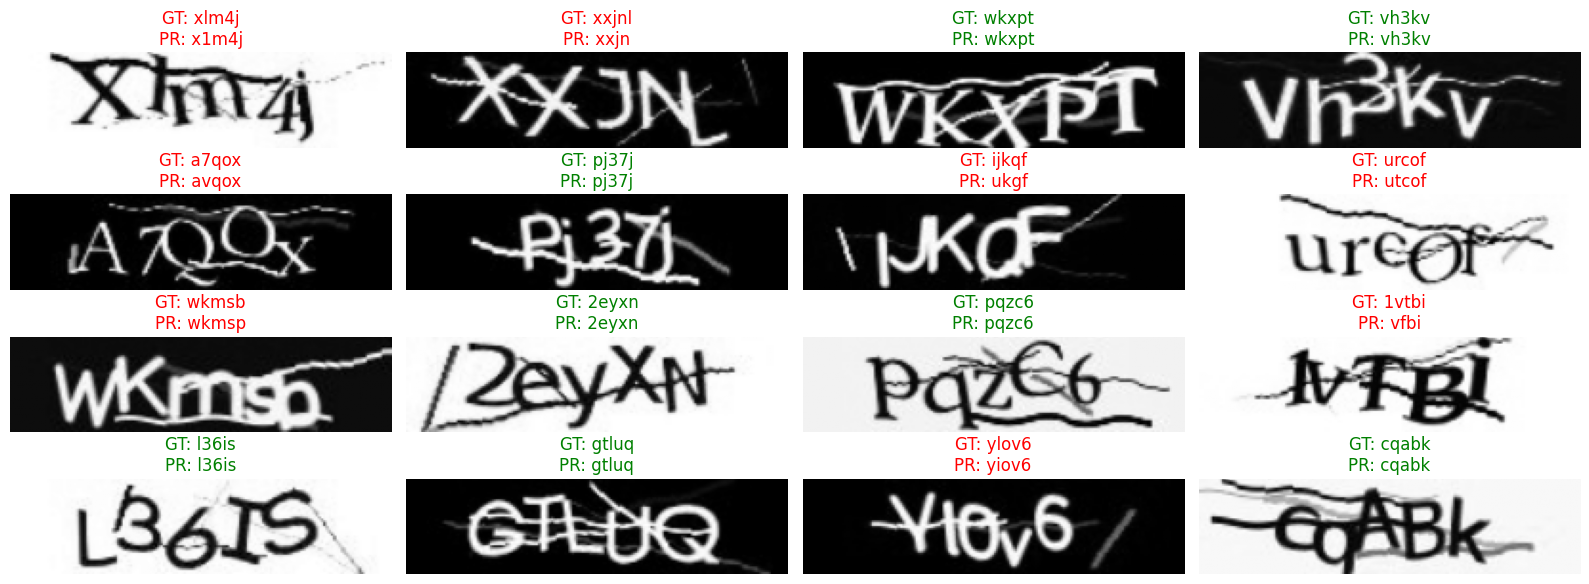


===== OCR PERFORMANCE =====
CER: 0.1374
Character Accuracy: 0.8626
Exact Match Accuracy: 0.5290


In [7]:
# =========================================================
# OCR TEST COMPLET (LOAD → PREDICT → VISUAL → METRICS)
# =========================================================

import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# ================= LOAD MODEL =================

model = keras.models.load_model(
    "ocr_final.keras",   # ou "ocr_best.keras"
    custom_objects={"CTCLayer": CTCLayer}
)
print("✅ Modèle chargé")

# modèle sans la couche CTC
prediction_model = keras.Model(
    model.input[0],
    model.layers[-2].output  # Dense softmax
)

# ================= CTC DECODING =================

def decode_predictions(preds):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]

    decoded, _ = tf.nn.ctc_greedy_decoder(
        inputs=tf.math.log(tf.transpose(preds, [1, 0, 2]) + 1e-8),
        sequence_length=input_len.astype(np.int32)
    )

    dense = tf.sparse.to_dense(decoded[0], default_value=-1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        chars = tf.gather(num_to_char, seq)
        texts.append(b"".join(chars.numpy()).decode("utf-8"))

    return texts


# ================= VISUAL TEST =================

for batch in val_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    preds = prediction_model.predict(images)
    pred_texts = decode_predictions(preds)

    true_texts = []
    for lab in labels:
        lab = lab[lab >= 0]
        chars = tf.gather(num_to_char, lab)
        true_texts.append(b"".join(chars.numpy()).decode("utf-8"))

    fig, axes = plt.subplots(4, 4, figsize=(16, 6))
    axes = axes.flatten()

    for i in range(16):
        img = images[i].numpy().squeeze().T
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(
            f"GT: {true_texts[i]}\nPR: {pred_texts[i]}",
            color="green" if true_texts[i] == pred_texts[i] else "red"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# ================= METRICS =================

def levenshtein(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current = list(range(n + 1))
    for i in range(1, m + 1):
        previous, current = current, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete = previous[j] + 1, current[j - 1] + 1
            change = previous[j - 1] + (a[j - 1] != b[i - 1])
            current[j] = min(add, delete, change)
    return current[n]


def evaluate_ocr(pred_model, dataset):
    total_chars, total_errors = 0, 0
    exact, total = 0, 0

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]

        preds = pred_model.predict(images, verbose=0)
        pred_texts = decode_predictions(preds)

        for lab, pred in zip(labels, pred_texts):
            lab = lab[lab >= 0]
            chars = tf.gather(num_to_char, lab)
            true = b"".join(chars.numpy()).decode("utf-8")

            total_errors += levenshtein(true, pred)
            total_chars += len(true)
            exact += int(true == pred)
            total += 1

    cer = total_errors / total_chars
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact / total,
    }


metrics = evaluate_ocr(prediction_model, val_dataset)

print("\n===== OCR PERFORMANCE =====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


In [8]:
# =========================================================
# OCR EVALUATION (APRES ENTRAINEMENT – UN SEUL BLOC)
# =========================================================

import numpy as np
import tensorflow as tf
import keras


# ---------------------------------------------------------
# 1) MODELE DE PREDICTION (sans CTC)
# ---------------------------------------------------------
prediction_model = keras.models.Model(
    model.input[0],
    model.get_layer(index=-2).output  # couche softmax
)


# ---------------------------------------------------------
# 2) DECODE CTC
# ---------------------------------------------------------
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    decoded, _ = tf.nn.ctc_greedy_decoder(
        inputs=tf.math.log(tf.transpose(pred, [1, 0, 2])),
        sequence_length=input_len.astype(np.int32),
    )

    decoded_dense = tf.sparse.to_dense(decoded[0], default_value=-1)

    texts = []
    for seq in decoded_dense:
        seq = tf.boolean_mask(seq, seq >= 0)
        chars = tf.gather(num_to_char, seq)
        text = tf.strings.reduce_join(chars).numpy().decode("utf-8")
        texts.append(text)

    return texts


# ---------------------------------------------------------
# 3) LEVENSHTEIN
# ---------------------------------------------------------
def levenshtein(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current = list(range(n + 1))
    for i in range(1, m + 1):
        previous, current = current, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete = previous[j] + 1, current[j - 1] + 1
            change = previous[j - 1]
            if a[j - 1] != b[i - 1]:
                change += 1
            current[j] = min(add, delete, change)

    return current[n]


# ---------------------------------------------------------
# 4) EVALUATION OCR (DONNEES JAMAIS VUES)
# ---------------------------------------------------------
def evaluate_ocr(prediction_model, dataset):
    total_chars = 0
    total_errors = 0
    exact_matches = 0
    total_samples = 0

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]

        preds = prediction_model.predict(images, verbose=0)
        pred_texts = decode_batch_predictions(preds)

        true_texts = []
        for lab in labels:
            lab = tf.boolean_mask(lab, lab >= 0)
            text = tf.strings.reduce_join(tf.gather(num_to_char, lab)).numpy().decode("utf-8")
            true_texts.append(text)

        for true, pred in zip(true_texts, pred_texts):
            dist = levenshtein(true, pred)
            total_errors += dist
            total_chars += len(true)
            exact_matches += int(true == pred)
            total_samples += 1

    cer = total_errors / total_chars
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact_matches / total_samples,
    }


# ---------------------------------------------------------
# 5) RUN
# ---------------------------------------------------------
metrics = evaluate_ocr(prediction_model, val_dataset)

print("\n===== OCR PERFORMANCE =====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



===== OCR PERFORMANCE =====
CER: 0.1374
Character Accuracy: 0.8626
Exact Match Accuracy: 0.5290


# ===============================================================

In [ ]:
# =========================================================
# OCR CAPTCHA - PIPELINE COMPLET FINAL (UN SEUL BLOC)
# =========================================================

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
from pathlib import Path
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt


# =========================================================
# 1) DATA
# =========================================================
data_dir = Path("../data/all_captcha_png_shuffled/")
all_images = sorted(list(data_dir.glob("*.png")))
all_labels = [img.stem.lower() for img in all_images]

np.random.seed(42)
idx = np.random.choice(len(all_images), 10_000, replace=False)

images = np.array([str(all_images[i]) for i in idx])
labels = np.array([all_labels[i] for i in idx])

perm = np.random.permutation(len(images))
images, labels = images[perm], labels[perm]

split = int(0.8 * len(images))
x_train, x_val = images[:split], images[split:]
y_train, y_val = labels[:split], labels[split:]


# =========================================================
# 2) VOCAB
# =========================================================
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
num_chars = len(characters)
num_classes = num_chars + 1  # blank

char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)
num_to_char = tf.constant(characters)

img_width, img_height = 200, 50
batch_size = 16


# =========================================================
# 3) DATASET
# =========================================================
def encode_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, [1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, "UTF-8"))
    return {"image": img, "label": tf.cast(label, tf.int32)}

def make_dataset(x, y):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(
        batch_size,
        padded_shapes={"image": [img_width, img_height, 1], "label": [None]},
        padding_values={"image": 0.0, "label": -1},
    )
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(x_train, y_train)
val_ds   = make_dataset(x_val, y_val)


# =========================================================
# 4) CTC LAYER
# =========================================================
class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch = tf.shape(y_true)[0]
        input_len = tf.fill([batch], tf.shape(y_pred)[1])
        label_len = tf.reduce_sum(tf.cast(y_true >= 0, tf.int32), axis=1)

        sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true, label_len)
        loss = tf.nn.ctc_loss(
            labels=sparse,
            logits=tf.math.log(tf.transpose(y_pred, [1,0,2]) + 1e-8),
            label_length=label_len,
            logit_length=input_len,
            blank_index=num_chars,
        )
        self.add_loss(tf.reduce_mean(loss))
        return y_pred


# =========================================================
# 5) MODEL CTC
# =========================================================
def build_ocr_ctc():
    img = layers.Input((img_width, img_height, 1), name="image")
    lbl = layers.Input((None,), dtype="int32", name="label")

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(img)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,1))(x)

    x = layers.Reshape((img_width//4, (img_height//2)*128))(x)
    x = layers.Dense(128, activation="relu")(x)

    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    y = layers.Dense(num_classes, activation="softmax")(x)
    out = CTCLayer()(lbl, y)

    model = keras.Model([img, lbl], out, name="ocr_ctc_base")
    model.compile(optimizer=keras.optimizers.Adam(1e-3))
    return model


# =========================================================
# 6) TRAIN + SAVE BEST
# =========================================================
ocr_ctc_base = build_ocr_ctc()

ocr_ctc_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
        keras.callbacks.ModelCheckpoint("ocr_ctc_best.keras", save_best_only=True),
    ],
)

# =========================================================
# 7) FINETUNE
# =========================================================
ocr_ctc_finetuned = keras.models.load_model(
    "ocr_ctc_best.keras", custom_objects={"CTCLayer": CTCLayer}
)

ocr_ctc_finetuned.compile(optimizer=keras.optimizers.Adam(1e-4))
ocr_ctc_finetuned.fit(train_ds, validation_data=val_ds, epochs=10)
ocr_ctc_finetuned.save("ocr_ctc_finetuned.keras")


# =========================================================
# 8) PREDICTOR + BEAM SEARCH
# =========================================================
ocr_predictor = keras.Model(
    ocr_ctc_finetuned.input[0],
    ocr_ctc_finetuned.layers[-2].output
)

def decode_beam(preds, beam_width=10):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded, _ = tf.nn.ctc_beam_search_decoder(
        tf.math.log(tf.transpose(preds,[1,0,2]) + 1e-8),
        input_len.astype(np.int32),
        beam_width=beam_width,
    )
    dense = tf.sparse.to_dense(decoded[0], -1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        texts.append(
            b"".join(tf.gather(num_to_char, seq).numpy()).decode()
        )
    return texts


# =========================================================
# 9) EVALUATION
# =========================================================
def levenshtein(a,b):
    if len(a)<len(b): a,b=b,a
    prev=list(range(len(b)+1))
    for i,c1 in enumerate(a):
        cur=[i+1]
        for j,c2 in enumerate(b):
            cur.append(min(prev[j+1]+1,cur[-1]+1,prev[j]+(c1!=c2)))
        prev=cur
    return prev[-1]

def evaluate(ds):
    tot_err=tot_char=exact=tot=0
    for batch in ds:
        preds = ocr_predictor.predict(batch["image"], verbose=0)
        texts = decode_beam(preds)
        for lab,p in zip(batch["label"],texts):
            lab=lab[lab>=0]
            gt=b"".join(tf.gather(num_to_char,lab).numpy()).decode()
            tot_err+=levenshtein(gt,p)
            tot_char+=len(gt)
            exact+=gt==p
            tot+=1
    return {
        "CER": tot_err/tot_char,
        "Character Accuracy": 1 - tot_err/tot_char,
        "Exact Match Accuracy": exact/tot,
    }

print("\n===== OCR PERFORMANCE =====")
print(evaluate(val_ds))


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step - loss: 20.2212 - val_loss: 19.1700 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 111ms/step - loss: 18.9907 - val_loss: 18.7731 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 117ms/step - loss: 18.7614 - val_loss: 18.6320 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 123ms/step - loss: 18.6598 - val_loss: 18.5864 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 18.5703 - val_loss: 18.4694 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 123ms/step - loss: 18.4159 - val_loss: 18.2897 - learning_rate: 0.0010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - loss: 18.2827 - val_loss: 18.1938 - learning_rate: 0.0010
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - loss: 17.9209 - val_loss: 17.5533 - learning_rate: 0.0010
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - loss: 17.1643 - val_los

✅ Modèle chargé


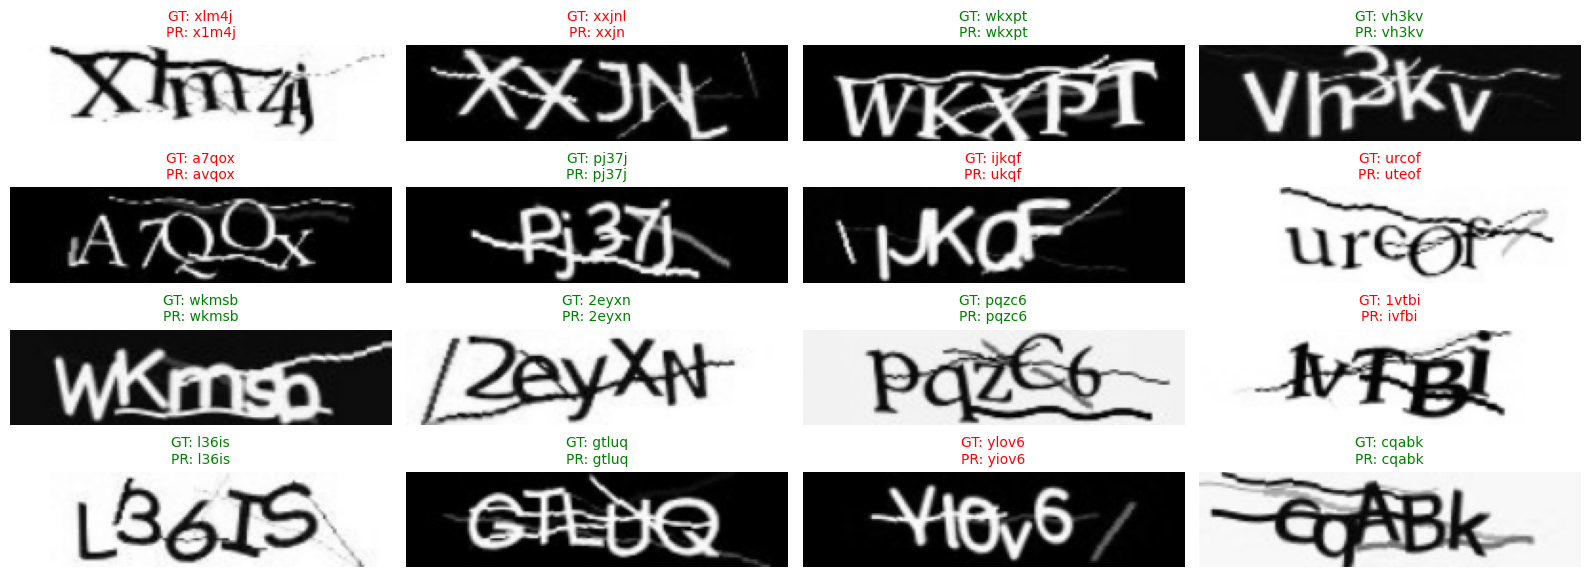

In [10]:
# =========================================================
# OCR TEST VISUEL (IMAGES + GT + PRED)
# =========================================================

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD MODEL =================

model = keras.models.load_model(
    "ocr_best.keras",   # ou ton nom final
    custom_objects={"CTCLayer": CTCLayer}
)
print("✅ Modèle chargé")

# modèle de prédiction (sans la couche CTC)
prediction_model = keras.Model(
    model.input[0],
    model.layers[-2].output  # Dense softmax
)

# ================= CTC DECODING =================

def decode_predictions(preds):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]

    decoded, _ = tf.nn.ctc_greedy_decoder(
        inputs=tf.math.log(tf.transpose(preds, [1, 0, 2]) + 1e-8),
        sequence_length=input_len.astype(np.int32)
    )

    dense = tf.sparse.to_dense(decoded[0], default_value=-1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        chars = tf.gather(num_to_char, seq)
        texts.append(b"".join(chars.numpy()).decode("utf-8"))

    return texts


# ================= VISUAL TEST =================

for batch in val_dataset.take(1):   # images jamais vues
    images = batch["image"]
    labels = batch["label"]

    preds = prediction_model.predict(images, verbose=0)
    pred_texts = decode_predictions(preds)

    true_texts = []
    for lab in labels:
        lab = lab[lab >= 0]
        chars = tf.gather(num_to_char, lab)
        true_texts.append(b"".join(chars.numpy()).decode("utf-8"))

    fig, axes = plt.subplots(4, 4, figsize=(16, 6))
    axes = axes.flatten()

    for i in range(16):
        img = images[i].numpy().squeeze().T
        axes[i].imshow(img, cmap="gray")

        color = "green" if true_texts[i] == pred_texts[i] else "red"
        axes[i].set_title(
            f"GT: {true_texts[i]}\nPR: {pred_texts[i]}",
            color=color,
            fontsize=10
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


✅ Modèle chargé


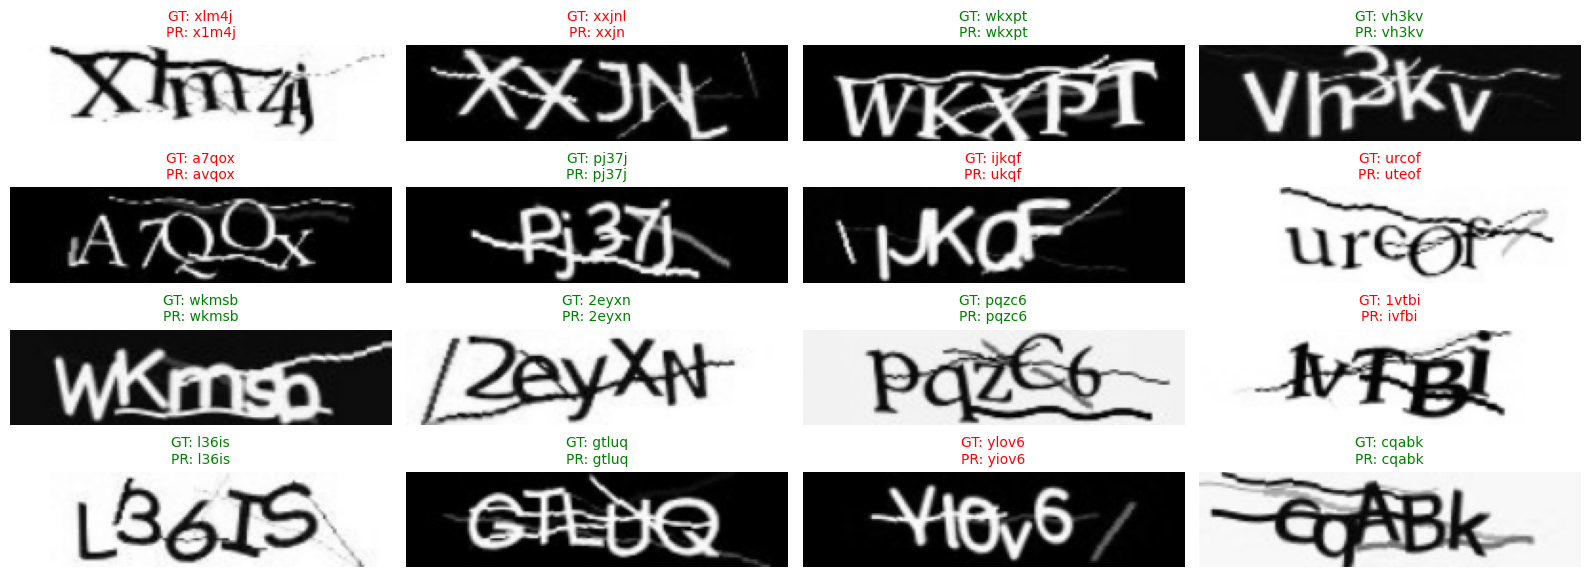


===== OCR PERFORMANCE (BEAM SEARCH) =====
CER: 0.1350
Character Accuracy: 0.8650
Exact Match Accuracy: 0.5295


In [11]:
# =========================================================
# OCR TEST + BEAM SEARCH (AVANT RETRAIN)
# =========================================================

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD MODEL =================

model = keras.models.load_model(
    "ocr_best.keras",
    custom_objects={"CTCLayer": CTCLayer}
)
print("✅ Modèle chargé")

# modèle sans la couche CTC
prediction_model = keras.Model(
    model.input[0],
    model.layers[-2].output  # Dense softmax
)

# ================= BEAM SEARCH DECODER =================

def decode_predictions_beam(preds, beam_width=10, max_len=None):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]

    decoded, _ = tf.nn.ctc_beam_search_decoder(
        inputs=tf.math.log(tf.transpose(preds, [1, 0, 2]) + 1e-8),
        sequence_length=input_len.astype(np.int32),
        beam_width=beam_width
    )

    dense = tf.sparse.to_dense(decoded[0], default_value=-1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        if max_len is not None:
            seq = seq[:max_len]
        chars = tf.gather(num_to_char, seq)
        texts.append(b"".join(chars.numpy()).decode("utf-8"))

    return texts


# ================= VISUAL TEST =================

for batch in val_dataset.take(1):  # données jamais vues
    images = batch["image"]
    labels = batch["label"]

    preds = prediction_model.predict(images, verbose=0)

    pred_texts = decode_predictions_beam(
        preds,
        beam_width=10,      # 🔥 gain immédiat
        max_len=6           # ⚠️ adapte si besoin (5 ou 6)
    )

    true_texts = []
    for lab in labels:
        lab = lab[lab >= 0]
        chars = tf.gather(num_to_char, lab)
        true_texts.append(b"".join(chars.numpy()).decode("utf-8"))

    fig, axes = plt.subplots(4, 4, figsize=(16, 6))
    axes = axes.flatten()

    for i in range(16):
        img = images[i].numpy().squeeze().T
        axes[i].imshow(img, cmap="gray")

        color = "green" if true_texts[i] == pred_texts[i] else "red"
        axes[i].set_title(
            f"GT: {true_texts[i]}\nPR: {pred_texts[i]}",
            color=color,
            fontsize=10
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# ================= METRICS =================

def levenshtein(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n
    current = list(range(n + 1))
    for i in range(1, m + 1):
        previous, current = current, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete = previous[j] + 1, current[j - 1] + 1
            change = previous[j - 1] + (a[j - 1] != b[i - 1])
            current[j] = min(add, delete, change)
    return current[n]


def evaluate_ocr_beam(pred_model, dataset):
    total_chars, total_errors = 0, 0
    exact, total = 0, 0

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]

        preds = pred_model.predict(images, verbose=0)
        pred_texts = decode_predictions_beam(preds, beam_width=10, max_len=6)

        for lab, pred in zip(labels, pred_texts):
            lab = lab[lab >= 0]
            chars = tf.gather(num_to_char, lab)
            true = b"".join(chars.numpy()).decode("utf-8")

            total_errors += levenshtein(true, pred)
            total_chars += len(true)
            exact += int(true == pred)
            total += 1

    cer = total_errors / total_chars
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact / total,
    }


metrics = evaluate_ocr_beam(prediction_model, val_dataset)

print("\n===== OCR PERFORMANCE (BEAM SEARCH) =====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


test de commit

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
from pathlib import Path
import tensorflow as tf
import keras
from keras import layers

# =========================================================
# 0) CONFIG
# =========================================================
DATA_DIR = Path("../data/all_captcha_png_shuffled/")
NUM_SAMPLES = 123_000   # mets None pour tout utiliser
SEED = 42

IMG_WIDTH, IMG_HEIGHT = 200, 50
BATCH_SIZE = 32

TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10
TEST_FRAC  = 0.10

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================================================
# 1) LOAD FILES
# =========================================================
all_images = sorted(list(DATA_DIR.glob("*.png")))
all_labels = [img.stem.lower() for img in all_images]

n_total = len(all_images)
if NUM_SAMPLES is None or NUM_SAMPLES > n_total:
    NUM_SAMPLES = n_total

idx = np.random.choice(n_total, NUM_SAMPLES, replace=False)

images = np.array([str(all_images[i]) for i in idx])
labels = np.array([all_labels[i] for i in idx])

perm = np.random.permutation(len(images))
images, labels = images[perm], labels[perm]

n = len(images)
n_train = int(TRAIN_FRAC * n)
n_val   = int(VAL_FRAC * n)

x_train, y_train = images[:n_train], labels[:n_train]
x_val,   y_val   = images[n_train:n_train+n_val], labels[n_train:n_train+n_val]
x_test,  y_test  = images[n_train+n_val:], labels[n_train+n_val:]

# =========================================================
# 2) VOCAB
# =========================================================
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
num_chars = len(characters)
num_classes = num_chars + 1

char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)
num_to_char = tf.constant(characters)

# =========================================================
# 3) DATA AUGMENTATION
# =========================================================
def augment_image(img):
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.6, 1.6)
    noise = tf.random.normal(tf.shape(img), 0.0, 0.03)
    img = tf.clip_by_value(img + noise, 0.0, 1.0)

    pad = 3
    img = tf.pad(img, [[pad,pad],[pad,pad],[0,0]])
    img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, 1])
    return img

# =========================================================
# 4) DATASET
# =========================================================
def encode_sample(path, label, training=False):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    if training:
        img = augment_image(img)

    img = tf.transpose(img, [1,0,2])  # width as time

    label = char_to_num(tf.strings.unicode_split(label, "UTF-8"))
    return {"image": img, "label": tf.cast(label, tf.int32)}

def make_dataset(x, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(50_000, seed=SEED)

    ds = ds.map(lambda a,b: encode_sample(a,b,training),
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.ignore_errors()   # ✅ version non dépréciée

    ds = ds.padded_batch(
        BATCH_SIZE,
        padded_shapes={"image":[IMG_WIDTH,IMG_HEIGHT,1], "label":[None]},
        padding_values={"image":0.0, "label":-1},
        drop_remainder=training
    )
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(x_train, y_train, training=True)
val_ds   = make_dataset(x_val, y_val, training=False)
test_ds  = make_dataset(x_test, y_test, training=False)

# =========================================================
# 5) CTC LAYER
# =========================================================
class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch = tf.shape(y_true)[0]
        input_len = tf.fill([batch], tf.shape(y_pred)[1])
        label_len = tf.reduce_sum(tf.cast(y_true >= 0, tf.int32), axis=1)

        sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true, label_len)

        loss = tf.nn.ctc_loss(
            labels=sparse,
            logits=tf.math.log(tf.transpose(y_pred,[1,0,2])+1e-8),
            label_length=label_len,
            logit_length=input_len,
            blank_index=num_chars
        )
        self.add_loss(tf.reduce_mean(loss))
        return y_pred

# =========================================================
# 6) MODEL
# =========================================================
def build_model():
    img = layers.Input((IMG_WIDTH,IMG_HEIGHT,1), name="image")
    lbl = layers.Input((None,), dtype="int32", name="label")

    x = layers.Conv2D(64,3,padding="same",activation="relu")(img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,1))(x)
    x = layers.Dropout(0.20)(x)

    x = layers.Reshape((IMG_WIDTH//4, (IMG_HEIGHT//2)*128))(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    y = layers.Dense(num_classes, activation="softmax")(x)
    out = CTCLayer()(lbl, y)

    model = keras.Model([img,lbl], out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3))
    return model

# =========================================================
# 7) TRAIN
# =========================================================
model = build_model()

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        keras.callbacks.ModelCheckpoint("ocr_ctc_robust_best.keras", save_best_only=True)
    ]
)

# =========================================================
# 8) FINETUNE (FREEZE CNN)
# =========================================================
model_ft = keras.models.load_model(
    "ocr_ctc_robust_best.keras",
    custom_objects={"CTCLayer": CTCLayer}
) # commm

for layer in model_ft.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False

model_ft.compile(optimizer=keras.optimizers.Adam(1e-4))
model_ft.fit(train_ds, validation_data=val_ds, epochs=10)

model_ft.save("ocr_ctc_robust_finetuned.keras")

print("\n✅ TRAINING FINISHED — MODEL SAVED")


Epoch 1/50
   3062/Unknown 695s 226ms/step - loss: 20.3028

c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3062/3062 ━━━━━━━━━━━━━━━━━━━━ 740s 241ms/step - loss: 19.2014 - val_loss: 18.7980 - learning_rate: 0.0010
Epoch 2/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 961s 314ms/step - loss: 18.5985 - val_loss: 18.2780 - learning_rate: 0.0010
Epoch 3/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 748s 244ms/step - loss: 15.9124 - val_loss: 7.0810 - learning_rate: 0.0010
Epoch 4/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 643s 210ms/step - loss: 5.4868 - val_loss: 2.2875 - learning_rate: 0.0010
Epoch 5/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 1020s 333ms/step - loss: 2.9350 - val_loss: 1.2920 - learning_rate: 0.0010
Epoch 6/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 649s 212ms/step - loss: 2.2233 - val_loss: 1.0270 - learning_rate: 0.0010
Epoch 7/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 644s 210ms/step - loss: 1.8856 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 8/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 924s 302ms/step - loss: 1.6815 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 9/50
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 699s 228ms/step - loss: 1.5575 - va

KeyboardInterrupt: 

In [5]:
# =========================================================
# LOAD + EVALUATE OCR CTC MODEL (ONE BLOCK)
# =========================================================

import numpy as np
import tensorflow as tf
import keras
from keras import layers

# -----------------------------
# CONFIG (DOIT MATCH TRAINING)
# -----------------------------
IMG_WIDTH, IMG_HEIGHT = 200, 50
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
num_chars = len(characters)
num_to_char = tf.constant(characters)

# -----------------------------
# CTC LAYER (OBLIGATOIRE)
# -----------------------------
class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        return y_pred

# -----------------------------
# LOAD BEST MODEL
# -----------------------------
model = keras.models.load_model(
    "ocr_ctc_robust_best.keras",
    custom_objects={"CTCLayer": CTCLayer}
)

print("✅ Model loaded")

# -----------------------------
# PREDICTOR (IMAGE → SOFTMAX)
# -----------------------------
ocr_predictor = keras.Model(
    model.input[0],
    model.layers[-2].output
)

# -----------------------------
# BEAM SEARCH DECODER
# -----------------------------
def decode_beam(preds, beam_width=10):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]

    decoded, _ = tf.nn.ctc_beam_search_decoder(
        tf.math.log(tf.transpose(preds, [1,0,2]) + 1e-8),
        input_len.astype(np.int32),
        beam_width=beam_width
    )

    dense = tf.sparse.to_dense(decoded[0], -1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        texts.append(
            b"".join(tf.gather(num_to_char, seq).numpy()).decode()
        )
    return texts

# -----------------------------
# LEVENSHTEIN DISTANCE
# -----------------------------
def levenshtein(a, b):
    if len(a) < len(b):
        a, b = b, a
    prev = list(range(len(b)+1))
    for i, c1 in enumerate(a):
        cur = [i+1]
        for j, c2 in enumerate(b):
            cur.append(min(
                prev[j+1] + 1,
                cur[-1] + 1,
                prev[j] + (c1 != c2)
            ))
        prev = cur
    return prev[-1]

# -----------------------------
# EVALUATION FUNCTION
# -----------------------------
def evaluate(ds, beam_width=10, max_batches=None):
    tot_err = tot_char = exact = tot = 0

    for i, batch in enumerate(ds):
        preds = ocr_predictor.predict(batch["image"], verbose=0)
        texts = decode_beam(preds, beam_width)

        for lab, pred in zip(batch["label"], texts):
            lab = lab[lab >= 0]
            gt = b"".join(tf.gather(num_to_char, lab).numpy()).decode()

            tot_err += levenshtein(gt, pred)
            tot_char += len(gt)
            exact += int(gt == pred)
            tot += 1

        if max_batches and i >= max_batches:
            break

    cer = tot_err / tot_char if tot_char else 1.0
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact / tot if tot else 0.0,
        "Samples": tot
    }

# -----------------------------
# RUN EVALUATION
# -----------------------------
print("\n===== VALIDATION PERFORMANCE =====")
print(evaluate(val_ds))

print("\n===== TEST PERFORMANCE =====")
print(evaluate(test_ds))

# -----------------------------
# QUICK RANDOM VISUAL TEST
# -----------------------------
def predict_single_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, [1,0,2])
    img = tf.expand_dims(img, axis=0)

    preds = ocr_predictor.predict(img, verbose=0)
    return decode_beam(preds, beam_width=10)[0]

# Example:
# print(predict_single_image("some_captcha.png"))


✅ Model loaded

===== VALIDATION PERFORMANCE =====
{'CER': 0.02111141598205207, 'Character Accuracy': 0.978888584017948, 'Exact Match Accuracy': 0.9026779882429784, 'Samples': 12248}

===== TEST PERFORMANCE =====
{'CER': 0.020052268180938245, 'Character Accuracy': 0.9799477318190618, 'Exact Match Accuracy': 0.9075918367346939, 'Samples': 12250}


In [9]:
print(predict_single_image("./data/sample/243mm.png"))

243mm


In [1]:
%pip install --upgrade pip setuptools wheel
%pip install numpy opencv-python tensorflow keras torch torchvision easyocr sympy==1.12 tqdm


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.2.0
    Uninstalling setuptools-63.2.0:
      Successfully uninstalled setuptools-63.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl.metadata (4.6 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached torch-2.9.1-cp310-cp310-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.24.1-cp310-cp310-win_amd64.whl.metadata (5.9 kB)
  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-p

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [9]:

def evaluate(ds, beam_width=10, max_batches=None):
    tot_err = tot_char = exact = tot = 0

    for i, batch in enumerate(ds):
        preds = ocr_predictor.predict(batch["image"], verbose=0)
        texts = decode_beam(preds, beam_width)

        for lab, pred in zip(batch["label"], texts):
            lab = lab[lab >= 0]
            gt = b"".join(tf.gather(num_to_char, lab).numpy()).decode()

            tot_err += levenshtein(gt, pred)
            tot_char += len(gt)
            exact += int(gt == pred)
            tot += 1

        if max_batches and i >= max_batches:
            break

    cer = tot_err / tot_char if tot_char else 1.0
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact / tot if tot else 0.0,
        "Samples": tot
    }

# -----------------------------
# RUN EVALUATION
# -----------------------------

# -----------------------------
# QUICK RANDOM VISUAL TEST
# -----------------------------
def predict_single_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, [1,0,2])
    img = tf.expand_dims(img, axis=0)

    preds = ocr_predictor.predict(img, verbose=0)
    return decode_beam(preds, beam_width=10)[0]


# BenchMark

In [ ]:
# =========================================================
# RUN BENCHMARK — SAME 1000 IMAGES (CTC vs EASYOCR)
# =========================================================

from pathlib import Path
import cv2
import easyocr
from keras import layers
import numpy as np 
import tensorflow as tf
import keras

num_to_char = tf.constant(characters)

def decode_beam(preds, beam_width=10):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded, _ = tf.nn.ctc_beam_search_decoder(
        tf.math.log(tf.transpose(preds,[1,0,2]) + 1e-8),
        input_len.astype(np.int32),
        beam_width=beam_width,
    )
    dense = tf.sparse.to_dense(decoded[0], -1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        texts.append(
            b"".join(tf.gather(num_to_char, seq).numpy()).decode()
        )
    return texts


# =========================================================
# 9) EVALUATION
# =========================================================
def levenshtein(a,b):
    if len(a)<len(b): a,b=b,a
    prev=list(range(len(b)+1))
    for i,c1 in enumerate(a):
        cur=[i+1]
        for j,c2 in enumerate(b):
            cur.append(min(prev[j+1]+1,cur[-1]+1,prev[j]+(c1!=c2)))
        prev=cur
    return prev[-1]

def evaluate(ds):
    tot_err=tot_char=exact=tot=0
    for batch in ds:
        preds = ocr_predictor.predict(batch["image"], verbose=0)
        texts = decode_beam(preds)
        for lab,p in zip(batch["label"],texts):
            lab=lab[lab>=0]
            gt=b"".join(tf.gather(num_to_char,lab).numpy()).decode()
            tot_err+=levenshtein(gt,p)
            tot_char+=len(gt)
            exact+=gt==p
            tot+=1
    return {
        "CER": tot_err/tot_char,
        "Character Accuracy": 1 - tot_err/tot_char,
        "Exact Match Accuracy": exact/tot,
    }

class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        return y_pred
    
model = keras.models.load_model(
    "ocr_ctc_robust_best.keras",
    custom_objects={"CTCLayer": CTCLayer}
)
ocr_predictor = keras.Model(
    model.input[0],
    model.layers[-2].output
)

DATA_DIR = Path("../data/all_captcha_png_shuffled/")
MAX_BENCH = 1000
BATCH_SIZE = 32
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
IMG_WIDTH, IMG_HEIGHT = 200, 50
# -----------------------------
# STRING LOOKUP (LABEL ENCODING)
# -----------------------------
char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)

# -----------------------------
# DATA ENCODING (MATCH TRAINING)
# -----------------------------
def encode_sample(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, [1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, "UTF-8"))
    return {"image": img, "label": tf.cast(label, tf.int32)}

# -----------------------------
# RECREATE TEST SPLIT
# -----------------------------
all_images = sorted(list(DATA_DIR.glob("*.png")))
all_labels = [img.stem.lower() for img in all_images]

n = len(all_images)
idx = np.random.permutation(n)

n_train = int(0.80 * n)
n_val   = int(0.10 * n)

test_idx = idx[n_train + n_val:]

x_test = np.array([str(all_images[i]) for i in test_idx])
y_test = np.array([all_labels[i] for i in test_idx])

# SAME 1000 IMAGES
x_bench = x_test[:MAX_BENCH]
y_bench = y_test[:MAX_BENCH]

print(f"\n Benchmark on {len(x_bench)} SAME images")

# -----------------------------
# TF DATASET FOR CTC
# -----------------------------
test_ds_1000 = tf.data.Dataset.from_tensor_slices((x_bench, y_bench))
test_ds_1000 = test_ds_1000.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_1000 = test_ds_1000.padded_batch(
    BATCH_SIZE,
    padded_shapes={"image": [IMG_WIDTH, IMG_HEIGHT, 1], "label": [None]},
    padding_values={"image": 0.0, "label": -1}
)
test_ds_1000 = test_ds_1000.prefetch(tf.data.AUTOTUNE)

# -----------------------------
# EASYOCR (STABLE CPU)
# -----------------------------
reader = easyocr.Reader(['en'], gpu=False)

def easyocr_predict(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return ""
    result = reader.readtext(
        img,
        detail=0,
        allowlist="0123456789abcdefghijklmnopqrstuvwxyz"
    )
    return result[0].lower().replace(" ", "") if result else ""

# -----------------------------
# EVALUATE EASYOCR
# -----------------------------
def evaluate_easyocr(x, y):
    tot_err = tot_char = exact = tot = 0

    for img, gt in zip(x, y):
        pred = easyocr_predict(img)
        tot_err += levenshtein(gt, pred)
        tot_char += len(gt)
        exact += int(gt == pred)
        tot += 1

    cer = tot_err / tot_char if tot_char else 1.0
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact / tot if tot else 0.0,
        "Samples": tot
    }

# -----------------------------
# RUN BENCHMARK
# -----------------------------
print("\n===== OCR CTC — TEST (1000 images) =====")
print(evaluate(test_ds_1000))

print("\n===== EASYOCR — TEST (1000 images) =====")
print(evaluate_easyocr(x_bench, y_bench))


Using CPU. Note: This module is much faster with a GPU.



📊 Benchmark on 1000 SAME images

===== OCR CTC — TEST (1000 images) =====
{'CER': 0.016758675078864353, 'Character Accuracy': 0.9832413249211357, 'Exact Match Accuracy': 0.925}

===== EASYOCR — TEST (1000 images) =====
{'CER': 0.48146687697160884, 'Character Accuracy': 0.5185331230283912, 'Exact Match Accuracy': 0.07, 'Samples': 1000}


In [2]:
# =========================================================
# RUN BENCHMARK — SAME 1000 IMAGES (CTC vs EASYOCR)
# =========================================================

from pathlib import Path
import cv2
import easyocr
from keras import layers
import numpy as np 
import tensorflow as tf
import keras

characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
num_to_char = tf.constant(characters)

def decode_beam(preds, beam_width=10):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded, _ = tf.nn.ctc_beam_search_decoder(
        tf.math.log(tf.transpose(preds,[1,0,2]) + 1e-8),
        input_len.astype(np.int32),
        beam_width=beam_width,
    )
    dense = tf.sparse.to_dense(decoded[0], -1)

    texts = []
    for seq in dense:
        seq = seq[seq >= 0]
        texts.append(
            b"".join(tf.gather(num_to_char, seq).numpy()).decode()
        )
    return texts


# =========================================================
# 9) EVALUATION
# =========================================================
def levenshtein(a,b):
    if len(a)<len(b): a,b=b,a
    prev=list(range(len(b)+1))
    for i,c1 in enumerate(a):
        cur=[i+1]
        for j,c2 in enumerate(b):
            cur.append(min(prev[j+1]+1,cur[-1]+1,prev[j]+(c1!=c2)))
        prev=cur
    return prev[-1]

def evaluate(ds):
    tot_err=tot_char=exact=tot=0
    for batch in ds:
        preds = ocr_predictor.predict(batch["image"], verbose=0)
        texts = decode_beam(preds)
        for lab,p in zip(batch["label"],texts):
            lab=lab[lab>=0]
            gt=b"".join(tf.gather(num_to_char,lab).numpy()).decode()
            tot_err+=levenshtein(gt,p)
            tot_char+=len(gt)
            exact+=gt==p
            tot+=1
    return {
        "CER": tot_err/tot_char,
        "Character Accuracy": 1 - tot_err/tot_char,
        "Exact Match Accuracy": exact/tot,
    }

class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        return y_pred
    
model = keras.models.load_model(
    "ocr_ctc_robust_best.keras",
    custom_objects={"CTCLayer": CTCLayer}
)
ocr_predictor = keras.Model(
    model.input[0],
    model.layers[-2].output
)

DATA_DIR = Path("../data/test/4_letters/")
MAX_BENCH = 1000
BATCH_SIZE = 32
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
IMG_WIDTH, IMG_HEIGHT = 200, 50
# -----------------------------
# STRING LOOKUP (LABEL ENCODING)
# -----------------------------
char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)

# -----------------------------
# DATA ENCODING (MATCH TRAINING)
# -----------------------------
def encode_sample(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, [1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, "UTF-8"))
    return {"image": img, "label": tf.cast(label, tf.int32)}

# -----------------------------
# RECREATE TEST SPLIT
# -----------------------------
all_images = sorted(list(DATA_DIR.glob("*.png")))
all_labels = [img.stem.lower() for img in all_images]

n = len(all_images)
idx = np.random.permutation(n)

n_train = int(0.80 * n)
n_val   = int(0.10 * n)

test_idx = idx[n_train + n_val:]

x_test = np.array([str(all_images[i]) for i in test_idx])
y_test = np.array([all_labels[i] for i in test_idx])

# SAME 1000 IMAGES
x_bench = x_test[:MAX_BENCH]
y_bench = y_test[:MAX_BENCH]

print(f"\n Benchmark on {len(x_bench)} SAME images")

# -----------------------------
# TF DATASET FOR CTC
# -----------------------------
test_ds_1000 = tf.data.Dataset.from_tensor_slices((x_bench, y_bench))
test_ds_1000 = test_ds_1000.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_1000 = test_ds_1000.padded_batch(
    BATCH_SIZE,
    padded_shapes={"image": [IMG_WIDTH, IMG_HEIGHT, 1], "label": [None]},
    padding_values={"image": 0.0, "label": -1}
)
test_ds_1000 = test_ds_1000.prefetch(tf.data.AUTOTUNE)

# -----------------------------
# EASYOCR (STABLE CPU)
# -----------------------------
reader = easyocr.Reader(['en'], gpu=False)

def easyocr_predict(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return ""
    result = reader.readtext(
        img,
        detail=0,
        allowlist="0123456789abcdefghijklmnopqrstuvwxyz"
    )
    return result[0].lower().replace(" ", "") if result else ""

# -----------------------------
# EVALUATE EASYOCR
# -----------------------------
def evaluate_easyocr(x, y):
    tot_err = tot_char = exact = tot = 0

    for img, gt in zip(x, y):
        pred = easyocr_predict(img)
        tot_err += levenshtein(gt, pred)
        tot_char += len(gt)
        exact += int(gt == pred)
        tot += 1

    cer = tot_err / tot_char if tot_char else 1.0
    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact / tot if tot else 0.0,
        "Samples": tot
    }

# -----------------------------
# RUN BENCHMARK
# -----------------------------
print("\n===== OCR CTC — TEST (1000 images) =====")
print(evaluate(test_ds_1000))

print("\n===== EASYOCR — TEST (1000 images) =====")
print(evaluate_easyocr(x_bench, y_bench))


Using CPU. Note: This module is much faster with a GPU.



 Benchmark on 1000 SAME images

===== OCR CTC — TEST (1000 images) =====
{'CER': 0.64975, 'Character Accuracy': 0.35024999999999995, 'Exact Match Accuracy': 0.041}

===== EASYOCR — TEST (1000 images) =====
{'CER': 0.78475, 'Character Accuracy': 0.21525000000000005, 'Exact Match Accuracy': 0.051, 'Samples': 1000}


## ZIP POUR ANAS

In [17]:
import os
import shutil
from pathlib import Path
from zipfile import ZipFile

# -----------------------------
# CONFIG
# -----------------------------
EXPORT_DIR = Path("benchmark_images_1000")
ZIP_PATH = Path("benchmark_images_1000.zip")

EXPORT_DIR.mkdir(exist_ok=True)

# -----------------------------
# COPY IMAGES
# -----------------------------
for img_path in x_bench:
    img_path = Path(img_path)
    shutil.copy(img_path, EXPORT_DIR / img_path.name)

print(f"✅ {len(list(EXPORT_DIR.iterdir()))} images copied")

# -----------------------------
# ZIP ARCHIVE
# -----------------------------
with ZipFile(ZIP_PATH, "w") as zipf:
    for img in EXPORT_DIR.iterdir():
        zipf.write(img, arcname=img.name)

print(f"📦 ZIP created: {ZIP_PATH.resolve()}")


✅ 1000 images copied
📦 ZIP created: C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\notebook\benchmark_images_1000.zip
